# Reinforcemnt Learning in the optimization of a Micro Grid

## Load Packages

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import time
import math
import torch
import gymnasium as gym
from datetime import datetime, timedelta
from matplotlib.ticker import FuncFormatter

import pymgrid
from pymgrid import Microgrid
from pymgrid.modules import (
    BatteryModule,
    LoadModule,
    RenewableModule,
    GridModule,
    GensetModule)
from pymgrid.envs import DiscreteMicrogridEnv
from pymgrid.envs import ContinuousMicrogridEnv

from dqn.dqn import DQN

from ppo.ppo import PPO, make_env_continuous, make_env_discrete
from ppo.ppo_agents import DiscreteAgent, ContinuousAgent


## Other functions

In [2]:
def check_time_series_lengths(modules):
    """
    Checks if all the time series within a list of modules have the same length.

    Parameters
    ----------
    modules : arraly-like 
        The modules that define the microgrid.

    Returns
    -------
    bool : 
        True if all time series have the same length, False otherwise.
          
    """
    time_series_lengths = []
    
    for module in modules:
        if isinstance(module, tuple):
            module = module[1]
        if hasattr(module, 'time_series'):
            time_series_lengths.append(module.time_series.shape[0])
    
    time_series_lengths = np.array(time_series_lengths)
    
    return np.all(time_series_lengths == time_series_lengths[0])

In [ ]:
def print_total_reward_microgrid(microgrid_results, days_to_simulate, hours_per_day):
    """
    Print summary statistics (sum, mean, std, max, min) for the total reward of a microgrid simulation.

    Parameters
    ----------
    microgrid_results : dataframe-like
        The results object returned by the microgrid simulation. The function expects
        that microgrid_results contains a balance attribute or key such that
        microgrid_results.balance[0]['reward'] is a 1-D array-like (e.g. numpy
        array or pandas Series) of numeric reward values for each simulated timestep.
    
    days_to_simulate : int
        Number of days that were simulated.
    
    hours_per_day : int
        Number of hours (timesteps) per simulated day.

    Returns
    -------
    None
        This function prints summary statistics.

    """
    rewards = microgrid_results.balance[0]['reward']
    print(f"The total reward of the microgrid is: "
          f"{rewards.sum():.2f}"
          )
    print(f"There are {rewards.shape[0]} simulations "
          f"which corresponds to {days_to_simulate} days and a total of {hours_per_day} hours per day.")
    
    print(f"\tMean: {rewards.mean():.2f}")
    print(f"\tStd: {rewards.std():.2f}")
    print(f"\tMax: {rewards.max():.2f}")
    print(f"\tMin: {rewards.min():.2f}")
   

In [ ]:
def plot_reward_per_month(microgrid_results, hours_per_day, title='Reward of microgrid per month'):
    """
    Plot monthly reward time series for a microgrid simulation.

    The function splits the full reward time series (taken from `microgrid_results.balance[0]['reward']`)
    into contiguous monthly chunks using a fixed calendar (January..December) and the provided
    `hours_per_day`.

    Parameters
    ----------
    microgrid_results : dataframe-like
        The results object returned by the microgrid simulation. The function expects that
        microgrid_results.balance[0]['reward'] is a 1-D array-like (e.g. numpy array or
        pandas Series) containing a reward value for each simulated timestep across the year.
    
    hours_per_day : int
        Number of timesteps per day (e.g. 24 for hourly simulations). Used to compute how many
        timesteps belong to each calendar month (`days_in_month * hours_per_day`).
    
    title : str, optional
        Overall figure title (default: 'Reward of microgrid per month').

    Returns
    -------
    None
        The function displays a Matplotlib figure

    """
    days_in_month = [
        ('January', 31),
        ('February', 28),
        ('March', 31),
        ('April', 30),
        ('May', 31),
        ('June', 30),
        ('July', 31),
        ('August', 31),
        ('September', 30),
        ('October', 31),
        ('November', 30),
        ('December', 31)
    ]
    rewards = microgrid_results.balance[0]['reward']
    
    rewards_per_month = []
    start = 0
    for month, days in days_in_month:
        num_simulations = days * hours_per_day
        rewards_per_month.append((month, rewards[start : start + num_simulations]))
        start += num_simulations
    
    num_months = len(rewards_per_month)
    ncols = 3
    nrows = math.ceil(num_months / ncols) 
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(25, 20),
                             sharex=False, sharey=False)
    axes = axes.flatten()   
    
    for i, rewards in enumerate(rewards_per_month):
        ax = axes[i]
        x = range(len(rewards[1])) 
        ax.plot(x, rewards[1])
        ax.set_title(rewards[0], fontsize=15)
        ax.set_xlabel('Step', fontsize=10)
        ax.set_ylabel('Reward', fontsize=10)
        ax.grid(True)

    for j in range(num_months, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [ ]:
def plot_csv(csv_file, title="DQN Escenario 0. Total reward", xlabel="Episode", ylabel="Total Reward"):
    """
    Plot two-column CSV data (Step vs Value) as a simple line chart.

    The function expects a CSV file with at least two columns named "Step" and "Value".

    Parameters
    ----------
    csv_file : str or pathlib.Path
        Path to the CSV file to read. The CSV must contain columns named "Step" and "Value".
    
    title : str, optional
        Title for the plot (default is "DQN Escenario 0. Total reward").
    
    xlabel : str, optional
        Label for the x-axis (default is "Episode").
    
    ylabel : str, optional
        Label for the y-axis (default is "Total Reward").

    Returns
    -------
    None
        The function displays a Matplotlib figure.

    """
    # Leer archivo
    df = pd.read_csv(csv_file)

    # Graficar
    plt.figure(figsize=(8, 5))
    plt.plot(df["Step"], df["Value"])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    plt.ticklabel_format(style='plain', axis='y')

    plt.show()

In [ ]:
def info_energy(microgrid_results):
    """
    Extract a subset of energy-related columns from microgrid results.

    The function currently selects the following variables (tuple format:
    (component, index, variable):
      - ('load', 0, 'load_current')
      - ('pv', 0, 'renewable_used')
      - ('battery', 0, 'discharge_amount')
      - ('battery', 0, 'charge_amount')
      - ('grid', 0, 'grid_import')
      - ('grid', 0, 'grid_export')

    Parameters
    ----------
    microgrid_results : dataframe-like
        The results object returned by the microgrid simulation.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame containing only the selected energy-related columns, in the
        same column MultiIndex format and order as specified in `wanted_columns`.

    """
    wanted_columns = [
        ('load',0,'load_current'),
        ('pv',0,'renewable_used'),
        ('battery',0,'discharge_amount'),
        ('battery',0,'charge_amount'),
        ('grid',0,'grid_import'),
        ('grid',0,'grid_export'),
        #('genset',0,'genset_production'),
    ]
    
    new_df = microgrid_results[wanted_columns]
    
    return new_df

In [ ]:
def plot_energy_used(microgrid_results, ini, end):
    """
    Plot energy flows (demand, PV used, battery charge/discharge, grid import/export)
    for a microgrid simulation over a slice of timesteps.

    The function extracts a subset of energy-related variables using info_energy()
    and draws a multi-line time series plot where loads (formatted as positive on the y-axis labels) 
    and exports (formatted as negative values on the y-axis) are shown.
    
    A set of vertical dotted lines are drawn for hourly visual reference and a vertical
    separator is drawn between days.

    Parameters
    ----------
    microgrid_results : dataframe-like
        The results object returned by the microgrid simulation.
    
    ini : int
        Start row index (inclusive) for the time window to plot.
    
    end : int
        End row index (exclusive) for the time window to plot.

    Returns
    -------
    None
        The function displays a Matplotlib figure.

    """
    meses_espanol = {
        'January': 'Enero',
        'February': 'Febrero',
        'March': 'Marzo',
        'April': 'Abril',
        'May': 'Mayo',
        'June': 'Junio',
        'July': 'Julio',
        'August': 'Agosto',
        'September': 'Septiembre',
        'October': 'Octubre',
        'November': 'Noviembre',
        'December': 'Diciembre'
    }
    fecha_base = datetime(2025, 1, 1)
    dia_inicio = (1416 // 24) + 1
    dia_fin = (1464 // 24)

    fecha_1 = fecha_base + timedelta(days=dia_inicio - 1)
    fecha_2 = fecha_base + timedelta(days=dia_fin - 1)

    dataframe_energy = info_energy(microgrid_results[ini:end]).reset_index()

    plt.figure(figsize=(12, 5))

    plt.plot(dataframe_energy.index, -1*dataframe_energy[('load',0,'load_current')], label='Demanda Energía', color='red')
    plt.plot(dataframe_energy.index, dataframe_energy[('pv', 0, 'renewable_used')]-dataframe_energy[('battery', 0, 'charge_amount')], label='Fotovoltaica Usada', color='green')
    plt.plot(dataframe_energy.index, -dataframe_energy[('battery', 0, 'charge_amount')], label='Carga Batería', color='orange', linestyle='--')
    plt.plot(dataframe_energy.index, dataframe_energy[('battery', 0, 'discharge_amount')], label='Descarga Batería', color='purple')
    plt.plot(dataframe_energy.index, dataframe_energy[('grid', 0, 'grid_import')], label='Importación Red', color='blue')
    plt.plot(dataframe_energy.index, -dataframe_energy[('grid', 0, 'grid_export')], label='Exportación Red', color='black', linestyle='--')
    #plt.plot(dataframe_energy.index, dataframe_energy[('genset',0,'genset_production')], label='Generador Produccion', color='teal')

    # Establece el eje negativo de y como positivo
    def positive_formatter(x, pos):
        return f'{abs(x):.0f}'
    formatter = FuncFormatter(positive_formatter)
    plt.gca().yaxis.set_major_formatter(formatter)

    # Lineas verticales para indicar cada hora
    plt.vlines(dataframe_energy.index, ymin=-max(dataframe_energy[('battery', 0, 'charge_amount')]), ymax=max(-1*dataframe_energy['load', 0, 'load_current']), 
               color='lightgray', linestyle='dotted', zorder=-1)
    # Linea vertical que separa los dias
    plt.vlines(23, ymin=-max(dataframe_energy[('battery', 0, 'charge_amount')]), ymax=max(-1*dataframe_energy['load', 0, 'load_current']), 
               color='dimgray', linestyle='dotted', zorder=-1)

    plt.title('Flujo de Energía en el sistema desde ' + str(fecha_1.day) + ' ' + meses_espanol[fecha_1.strftime('%B')] + ' hasta '
              + str(fecha_2.day) + ' ' + meses_espanol[fecha_2.strftime('%B')])
    plt.xlabel('Horas')
    plt.ylabel('Energía kWh')
    plt.grid(True)

    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

    plt.tight_layout() # Ajusta automáticamente los parámetros para que la gráfica quepa en la figura
    plt.show()

In [ ]:
def plot_action_taken(microgrid_results, ini, end):
    """
    Plot the actions taken by the agent in a microgrid simulation over a slice of timesteps.

    Parameters
    ----------
    microgrid_results : dataframe-like
        The results object returned by the microgrid simulation containing an `('action', 0)` column.
    
    ini : int
        Start row index (inclusive) for the time window to plot.
    
    end : int
        End row index (exclusive) for the time window to plot.

    Returns
    -------
    None
        The function displays a Matplotlib figure

    """
    meses_espanol = {
        'January': 'Enero',
        'February': 'Febrero',
        'March': 'Marzo',
        'April': 'Abril',
        'May': 'Mayo',
        'June': 'Junio',
        'July': 'Julio',
        'August': 'Agosto',
        'September': 'Septiembre',
        'October': 'Octubre',
        'November': 'Noviembre',
        'December': 'Diciembre'
    }
    fecha_base = datetime(2025, 1, 1)
    dia_inicio = (1416 // 24) + 1
    dia_fin = (1464 // 24)

    fecha_1 = fecha_base + timedelta(days=dia_inicio - 1)
    fecha_2 = fecha_base + timedelta(days=dia_fin - 1)

    dataframe_actions = microgrid_results[ini:end].reset_index()
    plt.figure(figsize=(12, 3))

    plt.scatter(dataframe_actions.index, dataframe_actions['action',0], marker='o', color='blue')
    
    plt.vlines(dataframe_actions.index, ymin=min(dataframe_actions['action',0]), ymax=max(dataframe_actions['action',0]), 
               color='lightgray', linestyle='dotted', zorder=-1)
    
    plt.ylim([-0.2, 11.2])
    plt.yticks(np.arange(0, 12, 1))
    plt.xlabel('Horas')
    plt.ylabel('Acción')
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.title('Acciones tomadas en el sistema desde ' + str(fecha_1.day) + ' ' + meses_espanol[fecha_1.strftime('%B')] + ' hasta '
              + str(fecha_2.day) + ' ' + meses_espanol[fecha_2.strftime('%B')])
    
    plt.show()

## Example of creating a microgrid

In [10]:
# The number of days to create the time series for the simulation of the microgrid
days_to_simulate = 365
# How many hours of simutation you want per day
#   24 --> every hour of the day as a simulation value
#   1 --> there is only one simulation for each day, means that all 24 hours of values per days 
#         are compressed (averaging has been done)  
hours_per_day = 1

np.random.seed(0)

small_battery = BatteryModule(min_capacity=10,
                              max_capacity=100,
                              max_charge=50,
                              max_discharge=50,
                              efficiency=0.9,
                              init_soc=0.2,
                              battery_cost_cycle=0.02)

large_battery = BatteryModule(min_capacity=10,
                              max_capacity=1000,
                              max_charge=10,
                              max_discharge=10,
                              efficiency=0.7,
                              init_soc=0.2,
                              battery_cost_cycle=0.02)

load_ts = -1*(100+200*np.random.rand(hours_per_day * days_to_simulate)) # random load data in the range [100, 200].
pv_ts = 200*np.random.rand(hours_per_day * days_to_simulate) # random pv data in the range [0, 200].

load = LoadModule(time_series=load_ts)

pv = RenewableModule(time_series=pv_ts)

grid_ts = [0.2, 0.1, 0.5] * np.ones((hours_per_day * days_to_simulate, 3))

grid = GridModule(max_import=100,
                  max_export=100,
                  time_series=grid_ts,
                  cost_per_unit_co2=0.2)

MODULES = [
    ('battery small', small_battery),
    ('battery large', large_battery),
    ('pv', pv),
    load,
    grid]

LOSS_LOAD_COST = 10
OVERGENERATION_COST = 2


microgrid= Microgrid(modules=MODULES, loss_load_cost=LOSS_LOAD_COST, overgeneration_cost=OVERGENERATION_COST)

## Usefull Scenarios

In [11]:
data = []
for i in range(25):
    # Load microgrid from scenario 0 to 25
    microgrid= Microgrid.from_scenario(microgrid_number=i)
    modules_dict = microgrid.modules.to_dict()
    
    if 'grid' not in modules_dict:
        continue

    scenario_df = {'id': i}
    load_module = modules_dict.get('load')
    scenario_df['mean_load'] = load_module[0].time_series.mean()

    pv_module = modules_dict.get('pv')
    if pv_module:
        scenario_df['mean_pv'] = pv_module[0].time_series.mean()
    else:
        scenario_df['mean_pv'] = None

    battery_module = modules_dict.get('battery')
    if battery_module:
        scenario_df['battery_max_capacity'] = battery_module[0].max_capacity
        scenario_df['battery_min_capacity'] = battery_module[0].min_capacity
    else:
        scenario_df['battery_max_capacity'] = None

    genset_module = modules_dict.get('genset')
    if genset_module:
        scenario_df['genset_max_production'] = genset_module[0].running_max_production
        scenario_df['genset_min_production'] = genset_module[0].running_min_production
    else:
        scenario_df['genset_max_production'] = None
        scenario_df['genset_min_production'] = None

    grid_module = modules_dict.get('grid')
    if grid_module:
        scenario_df['grid_max_import'] = grid_module[0].max_import
        scenario_df['grid_max_export'] = grid_module[0].max_export
    else:
        scenario_df['grid_max_import'] = None
        scenario_df['grid_max_export'] = None

    if genset_module:
        scenario_df['type'] = 'Industry/University'
    else:
        scenario_df['type'] = 'Housing'
    data.append(scenario_df)

scenario_df = pd.DataFrame(data).round(2)

styled_df = (
    scenario_df
      .style
      .hide(axis="index")
      .format("{:.2f}", subset=scenario_df.select_dtypes(include=["number"]).columns.difference(['id']))
)
styled_df

id,mean_load,mean_pv,battery_max_capacity,battery_min_capacity,genset_max_production,genset_min_production,grid_max_import,grid_max_export,type
0,-483.87,160.37,1452.00,290.40,nan,nan,1920.00,1920.00,Housing
1,-30424.61,5606.92,91274.00,18254.80,60363.00,3353.50,120726.00,120726.00,Industry/University
4,-16326.00,12111.60,65305.00,13061.00,nan,nan,99625.00,99625.00,Housing
6,-35874.46,8873.08,179373.00,35874.60,nan,nan,98432.00,98432.00,Housing
8,-26395.74,5922.50,105583.00,21116.60,64065.60,3559.20,128130.00,128130.00,Industry/University
9,-49896.70,26607.21,199587.00,39917.40,98996.40,5499.80,197992.00,197992.00,Industry/University
10,-43840.08,10193.37,219201.00,43840.20,60144.30,3341.35,120288.00,120288.00,Industry/University
11,-13918.72,5754.82,69594.00,13918.80,nan,nan,55230.00,55230.00,Housing
12,-28745.01,10895.25,143726.00,28745.20,nan,nan,96428.00,96428.00,Housing
13,-11888.75,1598.02,47556.00,9511.20,19941.30,1107.85,39882.00,39882.00,Industry/University


## Using Rule Based Control

In [ ]:
for i in range(25):
    print("\nMicrogrid from Scenario ", i)
    # Load microgrid from scenario 0 to 25
    microgrid_scenario = Microgrid.from_scenario(microgrid_number=i)
    rbc = pymgrid.algos.RuleBasedControl(microgrid=microgrid_scenario)

    rbc.reset()
    rbc_result = rbc.run()
    rbc_result.to_csv("rbc_results/microgrid_scenario_"+str(i)+".csv")

    print("Priority list: \n", rbc.priority_list)
    print("Total reward: \n", rbc_result.balance[0]['reward'].sum())


Microgrid from Scenario  0
Priority list: 
 [PriorityListElement(module=('battery', 0), module_actions=1, action=0, marginal_cost=0.02), PriorityListElement(module=('grid', 0), module_actions=1, action=0, marginal_cost=0.2439757908)]
Total reward: 
 -956059.6622849073

Microgrid from Scenario  1
Priority list: 
 [PriorityListElement(module=('battery', 0), module_actions=1, action=0, marginal_cost=0.02), PriorityListElement(module=('grid', 0), module_actions=1, action=0, marginal_cost=0.1039757908), PriorityListElement(module=('genset', 0), module_actions=2, action=0, marginal_cost=0.6000000000000001)]
Total reward: 
 -177196182.85938177

Microgrid from Scenario  2
Priority list: 
 [PriorityListElement(module=('battery', 0), module_actions=1, action=0, marginal_cost=0.02), PriorityListElement(module=('genset', 0), module_actions=2, action=0, marginal_cost=0.6000000000000001)]
Total reward: 
 -1097710381.7354746

Microgrid from Scenario  3
Priority list: 
 [PriorityListElement(module=('

In [23]:
results_microgrid_rbc = pd.read_csv("rbc_train/microgrid_scenario_22.csv", header=[0,1,2], index_col=0 )

In [24]:
# We change the name of the columns after reading the csv of the RBC algorithm due to it appers as
# ('battery', '0', 'charge_amount') and later we will need the '0' to appear as int
new_name_columns = pd.MultiIndex.from_tuples(
    [(mod_name, int(mod_num) if isinstance(mod_num, str) and mod_num.isdigit() else mod_num,field)
    for mod_name, mod_num, field in results_microgrid_rbc.columns],
    names=results_microgrid_rbc.columns.names
)

results_microgrid_rbc.columns = new_name_columns

In [25]:
print_total_reward_microgrid(results_microgrid_rbc, days_to_simulate=365, hours_per_day=24)
#plot_reward_per_month(results_microgrid_rbc, hours_per_day=24)

The total reward of the microgrid is: -44142821.01
There are 8759 simulations which corresponds to 365 days and a total of 24 hours per day.
	Mean: -5039.71
	Std: 2561.92
	Max: 0.00
	Min: -11166.20


In [28]:
# 1416:1464 correspond to 1st and 2nd March
df_info_energy = info_energy(results_microgrid_rbc[1416:1464])
df_info_energy

module_name            load             pv          battery                \
module_number             0              0                0                 
field          load_current renewable_used discharge_amount charge_amount   
1416          -45768.160206       0.000000         0.000000      0.000000   
1417          -46065.901123       0.000000         0.000000      0.000000   
1418          -46366.233392       0.000000         0.000000      0.000000   
1419          -46477.329267       0.000000         0.000000      0.000000   
1420          -51819.404909       0.000000         0.000000      0.000000   
1421          -51987.893991       0.000000         0.000000      0.000000   
1422          -65008.964200       0.000000         0.000000      0.000000   
1423          -71632.668621    6705.187764         0.000000      0.000000   
1424          -74189.280246   25522.972778         0.000000      0.000000   
1425          -76195.083127   45314.091500         0.000000      0.000000   
1426          -76690.935450   60130.393495         0.000000      0.000000   
1427          -77051.726731   69971.878761         0.000000      0.000000   
1428          -72845.896505   72459.287125         0.000000      0.000000   
1429          -73262.663248   68457.804105         0.000000      0.000000   
1430          -72038.364424   55047.428577         0.000000      0.000000   
1431          -71407.637959   35148.161665         0.000000      0.000000   
1432          -72418.724026   20007.415102         0.000000      0.000000   
1433          -74500.646785    4325.927590         0.000000      0.000000   
1434          -62040.297464       0.000000         0.000000      0.000000   
1435          -61904.543905       0.000000         0.000000      0.000000   
1436          -54365.205184       0.000000         0.000000      0.000000   
1437          -51998.899312       0.000000         0.000000      0.000000   
1438          -47963.603376       0.000000         0.000000      0.000000   
1439          -47983.218359       0.000000         0.000000      0.000000   
1440          -47116.498896       0.000000         0.000000      0.000000   
1441          -46961.362337       0.000000         0.000000      0.000000   
1442          -47014.805979       0.000000         0.000000      0.000000   
1443          -46996.731109       0.000000         0.000000      0.000000   
1444          -52004.583180       0.000000         0.000000      0.000000   
1445          -51950.443608       0.000000         0.000000      0.000000   
1446          -65259.234605       0.000000         0.000000      0.000000   
1447          -72198.583738    6597.039574         0.000000      0.000000   
1448          -73468.863181   15681.487512         0.000000      0.000000   
1449          -74134.177024   43259.275895         0.000000      0.000000   
1450          -73955.505239   55696.317715         0.000000      0.000000   
1451          -73381.964750   70512.619710         0.000000      0.000000   
1452          -71039.329686   73648.917212         0.000000   2609.587526   
1453          -72477.097488   65754.099361      2113.765896      0.000000   
1454          -71649.565247   59265.207977         0.000000      0.000000   
1455          -71013.760755   43583.720465         0.000000      0.000000   
1456          -71308.988108   23468.157173         0.000000      0.000000   
1457          -71558.727784    5191.113107         0.000000      0.000000   
1458          -58197.963833       0.000000         0.000000      0.000000   
1459          -61216.243773       0.000000         0.000000      0.000000   
1460          -54324.633144       0.000000         0.000000      0.000000   
1461          -52141.520017       0.000000         0.000000      0.000000   
1462          -48166.408227       0.000000         0.000000      0.000000   
1463          -48197.501726       0.000000         0.000000      0.000000   

module_name            grid              
module_number             0   

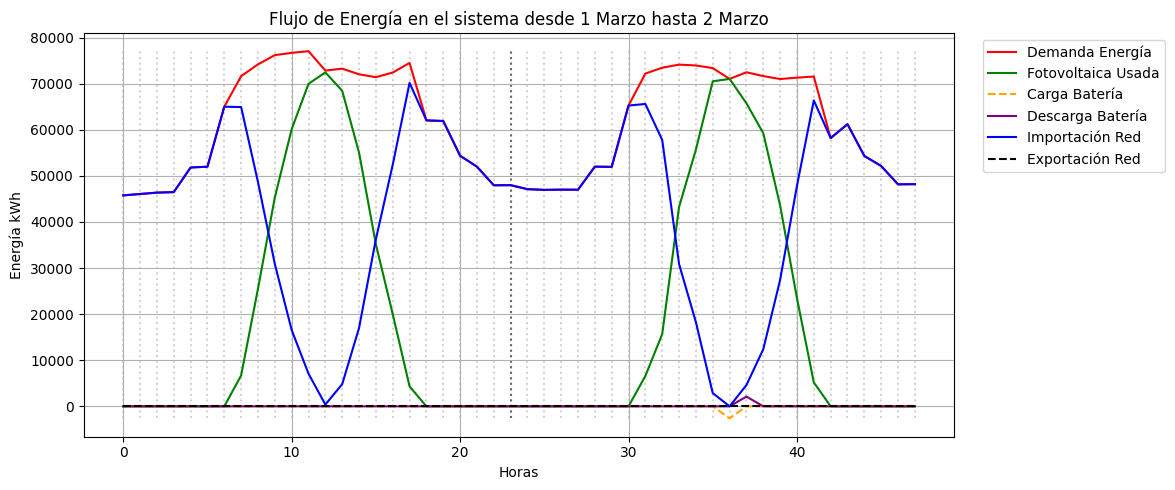

In [29]:
plot_energy_used(results_microgrid_rbc, 1416, 1464)

## Using Reinforcement Learning

### Functions and configuration

In [30]:
def create_environment(type_environment, modules, observation_keys, loss_load_cost=10, overgeneration_cost=2):
    """
    Creates a simulated environment based on the specified type and microgrid.

    Parameters
    ----------
    type_environment : str
        The type of environment, either 'discrete' or 'continuous'.

    modules : arraly-like 
        The modules that define the microgrid.

    Returns
    -------
    environment : DiscreteMicrogridEnv or ContinuousMicrogridEnv
        The created environment object.
    
    number_of_observations : int
        The number of observations available in the environment's observation space.
        
    number_of_actions : int
        The number of actions available in the environment's action space.
        
    Raises
    ------
    ValueError
        If the the shapes of the time_series of the mosules don not have the same values.
    ValueError
        If the `type_environment` is neither 'discrete' nor 'continuous'.
        
    """
    # Check if all modules that have a time_series attribute have the same number of values
    if not check_time_series_lengths(modules):
        raise ValueError("Not all the time series have the same values in some of the modules")
    
    # Create the stpecific enviroment
    if type_environment == 'discrete':
        environment = DiscreteMicrogridEnv(modules=modules, loss_load_cost=loss_load_cost, overgeneration_cost=overgeneration_cost, observation_keys=observation_keys)
        number_of_actions = environment.action_space.n
    elif type_environment == 'continuous':
        environment = ContinuousMicrogridEnv(modules=modules, loss_load_cost=loss_load_cost, overgeneration_cost=overgeneration_cost, observation_keys=observation_keys)
        number_of_actions = environment.action_space
    else:
        raise ValueError("Invalid type of environment. Must be 'discrete' or 'continuous'.")
    
    number_of_observations = environment.observation_space.shape[0]
    return environment, number_of_observations, number_of_actions

In [ ]:
# Needed for the enviroment, due to is necessary if we don´t want to have repeted observation variables in the observation space
OBSERVATION_KEYS = ['net_load', 'load_current', 'renewable_current', 'soc', 'current_charge', 'import_price_current', 'export_price_current',
                    'co2_per_kwh_current', 'grid_status_current']

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if isinstance(device, str):
    device = torch.device(device)

print("Working with:", device)
if device.type == "cuda":
  print("\tType of device:", torch.cuda.get_device_name(0))
  print("\tCUDA version for Pytorch:", torch.version.cuda)
  print("\tcuDNN versión:", torch.backends.cudnn.version())

Working with: cuda:0
	Type of device: NVIDIA GeForce RTX 3080 Ti
	CUDA version for Pytorch: 12.8
	cuDNN versión: 90701


### Find best hiperparameters for DQN

In [ ]:
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.basic_variant import BasicVariantGenerator
from ray.tune import CLIReporter
from ray.tune import TuneConfig, RunConfig
from ray.air import session

ray.init(num_cpus=24, num_gpus=1)

In [ ]:
# Set all posible hyperparameters and their values
config = {
    "memory_size": tune.choice([200000, 100000]),
    "batch_size": tune.choice([1024]),
    "learning_rate": tune.choice([1e-3]),
    "exploration_decay": tune.choice([0.99995, 0.99999]),
    "hidden_layers": tune.choice([[32], [64], [32,32], [64,64]]),
    "train_episodes": tune.choice([10, 20, 25]),
    "eval_episodes": 1,
    "target_update_freq": tune.choice([1000, 4000, 8000]),
}

In [13]:
def train_dqn(config, device, num_scenario):
    import torch
    import random
    import numpy as np
    
    # Set seeds
    seed = 1234
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 

    # Create the scenario
    environment = DiscreteMicrogridEnv.from_scenario(microgrid_number=num_scenario)
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n

    # Create the DQN model
    agent = DQN.DQN(
        memory_size=config["memory_size"],
        number_of_observations=number_of_observations,
        number_of_actions=number_of_actions,
        exploration_max=1.0,
        exploration_decay=config["exploration_decay"],
        exploration_min=0.01,
        gamma=0.99,
        batch_size=int(config["batch_size"]),
        hidden_layers=config["hidden_layers"],
        device=device,
        learning_rate=config["learning_rate"],
        run_name=session.get_trial_name(),
        seed=seed
    )
    
    # Tarin the model cretaed
    agent.train(
        environment,
        num_episodes_training=int(config["train_episodes"]),
        num_episodes_update_target=int(config["target_update_freq"])
    )
    
    rewards = environment.log.balance[0]['reward']
    tune.report({"mean_reward": rewards.mean(), "total_reward": rewards.sum()})



In [ ]:
scheduler = ASHAScheduler(
    metric="mean_reward", mode="max",
    max_t=300, grace_period=50, reduction_factor=2
)

# Set the algorithm for hyperparameters search
optuna_search = OptunaSearch(metric="mean_reward", mode="max", seed=1234)
random_search  = BasicVariantGenerator(random_state=1234)

# Set the features to report during the search
reporter = CLIReporter(
    parameter_columns=["learning_rate", "gamma", "batch_size", "hidden_layers", "train_episodes", "target_update_freq", "memory_size"],
    metric_columns=["mean_reward", "total_reward","training_iteration"]
)

In [15]:
# Which scenario are we working on
num_scenario = 22

trainable = tune.with_parameters(
    train_dqn,
    device=device,
    num_scenario=num_scenario,
)

trainable_gpu = tune.with_resources(
    trainable,
    resources={"cpu": 6, "gpu": 0.3}
)

tuner = tune.Tuner(
    trainable,
    param_space=config,
    tune_config=TuneConfig(
        scheduler=scheduler,
        search_alg=optuna_search,
        num_samples=20
    ),
    #run_config=RunConfig(storage_path="~/logs/dqn", name="Scenary_"+str(num_scenario)),
)
results = tuner.fit()


2025-08-19 15:06:26,316	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/angel/ray_results/train_dqn_2025-08-19_13-30-43' in 0.0079s.
2025-08-19 15:06:26,319	INFO tune.py:1041 -- Total run time: 5743.19 seconds (5743.17 seconds for the tuning loop).


In [16]:
best = results.get_best_result(metric="mean_reward", mode="max")
print("Best mean return for microgrid:", best.metrics["mean_reward"])
print("Best hiperparameters:", best.config)


Best mean return for microgrid: -5113.359704657796
Best hiperparameters: {'memory_size': 100000, 'batch_size': 1024, 'learning_rate': 0.001, 'exploration_decay': 0.99995, 'hidden_layers': [64], 'train_episodes': 25, 'eval_episodes': 1, 'target_update_freq': 8000}


### Training best DQN

In [ ]:
# Hyperparameters

# Specific for DQN algorithm
exploration_max = 1
exploration_min = 0.01
exploration_decay = 0.99995
gamma = 0.99

memory_size = 100000

number_of_episodes_for_training = 25
setps_update_target_network = 8000

# For DQN networks
hidden_layers = [64]
learning_rate = 1e-3
batch_size = 1024

In [ ]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

#environment, number_of_observations, number_of_actions = create_environment('discrete', modules=MODULES, observation_keys=OBSERVATION_KEYS, loss_load_cost=LOSS_LOAD_COST, overgeneration_cost=OVERGENERATION_COST)

environment = DiscreteMicrogridEnv.from_scenario(microgrid_number=22)
number_of_observations = environment.observation_space.shape[0]
number_of_actions = environment.action_space.n


print("\nEnviroment: ", environment)
print("Number of observations: ", number_of_observations)
print("Number of actions: ", number_of_actions)
print("\nAll posible actions are:")
for i in range(number_of_actions):
    print(f"Action {i}: {environment.actions_list[i]}")
print("\n")

# Create the DQN agent
model_dqn = DQN(memory_size, number_of_observations, number_of_actions, exploration_max, exploration_decay, exploration_min, gamma, 
                batch_size, hidden_layers, device, learning_rate, run_name='escenario_22', seed=seed)
#model_dqn.print_summay()

model_dqn.train(environment, number_of_episodes_for_training, setps_update_target_network)

#model_dqn.display_scores_graphically()

In [ ]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

model_dqn.test(environment, num_episodes_testing=1)
total_reward_test = environment.log.balance[0]['reward'].sum()
mean_reward_test = environment.log.balance[0]['reward'].mean()

print("Total reward in test: ", total_reward_test)
print("Mean reward in test: ", mean_reward_test)

In [ ]:
info_energy(environment.log[1416:1464])

In [ ]:
plot_energy_used(environment.log, 1416, 1464)

In [ ]:
plot_action_taken(environment.log, 1416, 1464)

### Find best hiperparameters for PPO

In [ ]:
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.basic_variant import BasicVariantGenerator
from ray.tune import CLIReporter
from ray.tune import TuneConfig, RunConfig
from ray.air import session

ray.init(num_cpus=24, num_gpus=1)

In [ ]:
num_envs = 1
clip_threshold = 0.2
value_loss_coefficient = 0.5
gamma = 0.99
gae_lambda = 0.95
normalize_advantages = True
entropy_loss_coefficient = 0.0
target_kl_earlystop = None
max_grad_norm = 0.5

# Set all posible hyperparameters and their values
config = {
    "total_timesteeps": tune.choice([10*8760, 20*8760, 25*8760]),
    "num_rollout_steps": tune.choice([1024, 2048]),
    "num_epochs": tune.choice([10, 15]),
    "minibatch_size": tune.choice([32, 64]),
    #"clip_threshold": tune.choice([0.2, 0.3]),
    #"value_loss_coefficient": tune.choice([0.5]),
    "learning_rate": tune.choice([0.001, 0.01]),
    #"max_grad_norm": tune.choice([0.5]),
    "hidden_layers_critic": tune.choice([[32], [64], [128], [64,64]]),
    "hidden_layers_actor": tune.choice([[32], [64], [128], [64,64]]),
}

In [ ]:
def train_ppo(config, device, num_scenario):
    import torch
    import random
    import numpy as np
    
    # Set seeds
    seed = 1234
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 

    # Create the scenario
    def create_new_microgrid_env_instance():
        return DiscreteMicrogridEnv.from_scenario(microgrid_number=0)

    environment = DiscreteMicrogridEnv.from_scenario(microgrid_number=0)
    number_of_observations = environment.observation_space
    number_of_actions = environment.action_space.n
    max_episode_steps = environment.pv[0].time_series.shape[0]
    # Make vectorized enviroment
    vectorized_environments = gym.vector.SyncVectorEnv([make_env_discrete(create_new_microgrid_env_instance, seed + i, max_episode_steps) for i in range(num_envs)])

    # Create the Agent
    ppo_agent = DiscreteAgent(vectorized_environments, config["hidden_layers_critic"], config["hidden_layers_actor"], device, summary_batch_size=32).to(device)

    name_experiment = "ppo_test"
    # Create the PPO

    ppo = PPO(name_experiment, ppo_agent, vectorized_environments, config["learning_rate"], max_grad_norm, config["num_rollout_steps"], 
              config["num_epochs"], config["minibatch_size"], gamma, gae_lambda, normalize_advantages, clip_threshold,
              entropy_loss_coefficient, value_loss_coefficient, target_kl_earlystop, device, seed, verbose=False)

    ppo.learn(config["total_timesteeps"])
    
    episode_returns, mean_return = ppo.test(environment, num_episodes_testing=1)
    tune.report({"mean_reward": mean_return, "total_reward": episode_returns})



In [ ]:
scheduler = ASHAScheduler(
    metric="mean_reward", mode="max",
    max_t=300, grace_period=50, reduction_factor=2
)

# Set the algorithm for hyperparameters search
optuna_search = OptunaSearch(metric="mean_reward", mode="max", seed=1234)
random_search  = BasicVariantGenerator(random_state=1234)

# Set the features to report during the search
reporter = CLIReporter(
    parameter_columns=["learning_rate", "gamma", "batch_size", "hidden_layers", "train_episodes", "target_update_freq", "memory_size"],
    metric_columns=["mean_reward", "total_reward","training_iteration"]
)

In [19]:
# Which scenario are we working on
num_scenario = 0

trainable = tune.with_parameters(
    train_ppo,
    device=device,
    num_scenario=num_scenario,
)

trainable_gpu = tune.with_resources(
    trainable,
    resources={"cpu": 6, "gpu": 0.3}
)

tuner = tune.Tuner(
    trainable,
    param_space=config,
    tune_config=TuneConfig(
        scheduler=scheduler,
        search_alg=optuna_search,
        num_samples=20
    ),
    #run_config=RunConfig(storage_path="~/logs/dqn", name="Scenary_"+str(num_scenario)),
)
results = tuner.fit()


2025-08-20 01:51:40,115	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/angel/ray_results/train_ppo_2025-08-20_00-49-00' in 0.0079s.
2025-08-20 01:51:40,118	INFO tune.py:1041 -- Total run time: 3759.54 seconds (3759.52 seconds for the tuning loop).


In [ ]:
best = results.get_best_result(metric="mean_reward", mode="max")
print("Best mean return for microgrid:", best.metrics["mean_reward"])
print("Best hiperparameters:", best.config)

Best mean return for microgrid: -109.1516910931505
Best hiperparameters: {'total_timesteeps': 87600, 'num_rollout_steps': 2048, 'num_epochs': 10, 'minibatch_size': 32, 'learning_rate': 0.01, 'hidden_layers_critic': [128], 'hidden_layers_actor': [64, 64]}


### Training best PPO

In [ ]:
# Hyperparameters

# For the Agent
hidden_layers_critic = [128]
hidden_layers_actor = [64,64]

# Specific params for the PPO algorithm
total_timesteeps = 87900

num_envs = 1
num_rollout_steps = 2048
num_epochs = 10
minibatch_size = 32
gamma = 0.99
gae_lambda = 0.95
normalize_advantages = True
clip_threshold = 0.2
entropy_loss_coefficient = 0.0
value_loss_coefficient = 0.5
target_kl_earlystop = None

# Optimizer
learning_rate = 0.01
max_grad_norm = 0.5

#beta_1=0.9
#beta_2=0.999
#epsilon=1e-07

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Working with:", device)
if device.type == "cuda":
  print("\tType of device:", torch.cuda.get_device_name(0))

In [ ]:
# Set seeds
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

type_enviroment = 'continuos'

def create_new_microgrid_env_instance():
    #env, _, _ = create_environment(type_enviroment, modules=MODULES, observation_keys=OBSERVATION_KEYS, loss_load_cost=LOSS_LOAD_COST, overgeneration_cost=OVERGENERATION_COST)
    return DiscreteMicrogridEnv.from_scenario(microgrid_number=22)

environment = DiscreteMicrogridEnv.from_scenario(microgrid_number=22)
number_of_observations = environment.observation_space
number_of_actions = environment.action_space


print("\nEnviroment: ", environment)
print("Number of observations: ", number_of_observations)
print("Number of actions: ", number_of_actions)
if type_enviroment == 'discrete':
    print("\nAll posible actions are:")
    for i in range(number_of_actions):
        print(f"Action {i}: {environment.actions_list[i]}")
print("\n")

max_episode_steps = environment.pv[0].time_series.shape[0]
# Make vectorized enviroment
vectorized_environments = gym.vector.SyncVectorEnv([make_env_discrete(create_new_microgrid_env_instance, seed + i, max_episode_steps) for i in range(num_envs)])

# Create the Agent
ppo_agent = DiscreteAgent(vectorized_environments, hidden_layers_critic, hidden_layers_actor, device, summary_batch_size=32).to(device)

name_experiment = "escenario_22"
# Create the PPO

ppo = PPO(name_experiment, ppo_agent, vectorized_environments, learning_rate, max_grad_norm, num_rollout_steps, num_epochs, minibatch_size, gamma, gae_lambda, normalize_advantages, clip_threshold,
          entropy_loss_coefficient, value_loss_coefficient, target_kl_earlystop, device, seed, verbose=True)

ppo.learn(total_timesteeps)

In [ ]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

total_reward_test, mean_reward_test = ppo.test(environment, num_episodes_testing=1)
print("Total reward in test: ", total_reward_test)
print("Mean reward in test: ", mean_reward_test)

In [ ]:
info_energy(environment.log[1416:1464])

In [ ]:
plot_energy_used(environment.log, 1416, 1464)

In [ ]:
plot_action_taken(environment.log, 1416, 1464)